In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer,OneHotEncoder
from pyspark.sql import SQLContext, SparkSession, Row
from pyspark.mllib.stat import Statistics
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StandardScaler
from pyspark.sql.functions import col
import pyspark.sql.functions as F
from pyspark.sql.functions import when, count, isnull
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import FloatType

from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import MulticlassMetrics

from pyspark.ml.functions import vector_to_array

import pyspark.sql.functions as F

spark = SparkSession.Builder().appName('DDAM_Project_est').getOrCreate()
df = spark.read.options(inferSchema = True, delimiter = ',', header = True).csv('../../Datasets/East_Incidents_Cleaned.csv')
df.show()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/14 22:26:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/14 22:26:42 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+-------------------+------------------+------------------+-----------+---------+---------+-----+-------------+-------------+-------------+--------------+--------------+----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+-----+---------------+----+------+---------------+---------------------+
|Severity|         Start_Time|         Start_Lat|         Start_Lng|Distance_mi|     City|   County|State|Temperature_F|Humidity_perc|Visibility_mi|Wind_Direction|Wind_Speed_mph|Precipitation_in|Weather_Condition|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|month|day_of_the_week|hour|season|Working_Weekend|Astronomical_Twilight|
+--------+-------------------+------------------+------------------+-----------+---------+---------+-----+-------------+-------------+-------------+--------------+--------------+----------------+-------

In [2]:
to_drop=['Start_Time','City','County','State','Wind_Direction','day_of_the_week','season']
df_class=df.drop(*to_drop)
colonne_booleane = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']

# Converti le colonne booleane in numeriche
for col_name in colonne_booleane:
    df_class = df_class.withColumn(col_name, col(col_name).cast("int"))


df_class = df_class.withColumn("Astronomical_Twilight", when(df_class["Astronomical_Twilight"] == 'Day', 0).otherwise(1))
df_class = df_class.withColumn("Working_Weekend", when(df_class["Working_Weekend"] == 'WorkingDay', 0).otherwise(1))

indexer = StringIndexer(inputCol="Weather_Condition", outputCol="Weather_Condition_Indexed")
df_class = indexer.fit(df_class).transform(df_class)

onehotencoder_vector = OneHotEncoder(inputCol="Weather_Condition_Indexed", outputCol="Weather_Condition_1hot")
df_class = onehotencoder_vector.fit(df_class).transform(df_class)

df_class=df_class.drop('Weather_Condition')
df_class=df_class.drop('Weather_Condition_Indexed')
df_class= df_class.withColumn("Severity", col("Severity") - 1)


num_col = [item[0] for item in df_class.dtypes if not item[1].startswith('string')]
num_col.remove("Severity")

assembler = VectorAssembler(inputCols=num_col, outputCol="features")

output_dataset = assembler.transform(df_class)

classificationData = output_dataset.select("features", "Severity")

classificationData.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------+--------+
|features                                                                                                   |Severity|
+-----------------------------------------------------------------------------------------------------------+--------+
|(28,[0,1,3,4,5,17,20,21,24],[33.032551,-81.346909,30.0,93.0,10.0,1.0,3.0,6.0,1.0])                         |1       |
|(28,[0,1,2,3,4,5,6,17,20,21,25],[33.023018,-81.274361,0.129,73.0,47.0,10.0,6.0,1.0,3.0,14.0,1.0])          |1       |
|(28,[0,1,2,3,4,5,6,20,21,24],[33.023848,-81.33301800000002,0.122,82.0,15.0,10.0,7.0,3.0,14.0,1.0])         |1       |
|(28,[0,1,3,4,5,20,21],[33.087425,-81.208588,46.0,100.0,0.25,3.0,7.0])                                      |1       |
|(28,[0,1,3,4,5,17,20,21,24],[33.06987,-81.424118,59.0,94.0,10.0,1.0,3.0,6.0,1.0])                          |1       |
|(28,[0,1,3,4,5,10,14,20,21,25],[32.920799,-81.2

In [3]:
df_DT_binary=df_class

In [4]:
(trainingData, testData) = classificationData.randomSplit([0.7, 0.3],seed=0)

In [5]:
g=trainingData.groupBy('Severity').agg(F.count('Severity').alias('Count'))
g=g.sort('Severity')
g.show()

+--------+------+
|Severity| Count|
+--------+------+
|       0|  8918|
|       1|246675|
|       2|  9859|
|       3| 10956|
+--------+------+



Train & Test a DT without Severity sampling

In [6]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier

dt = DecisionTreeClassifier(labelCol="Severity", featuresCol="features")

dt = dt.fit(trainingData)

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=40491Kb max_used=40501Kb free=90580Kb
 bounds [0x00000001089d8000, 0x000000010b1a8000, 0x00000001109d8000]
 total_blobs=14426 nmethods=13370 adapters=968
 compilation: disabled (not enough contiguous free space left)


In [7]:
dt.featureImportances

SparseVector(28, {0: 0.0723, 1: 0.0074, 2: 0.5556, 19: 0.0019, 20: 0.2465, 21: 0.0692, 22: 0.0471})

In [8]:
predictions = dt.transform(testData)
evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

0.9186358594881087
Test Error = 0.0813641


In [9]:
preds_and_labels = predictions.select(['prediction','Severity']).withColumn('label', F.col('Severity').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix())

/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


DenseMatrix([[3.27300e+03, 3.62000e+02, 1.09000e+02, 0.00000e+00],
             [1.18600e+03, 1.03069e+05, 1.12800e+03, 0.00000e+00],
             [6.30000e+02, 1.51400e+03, 2.15900e+03, 0.00000e+00],
             [9.00000e+00, 4.66100e+03, 1.10000e+01, 0.00000e+00]])


Train & Test a tuned DT without Severity sampling

In [11]:
n=trainingData.count()
max_depth=[5,15,25]
max_bins=[32,64]
min_inst=[round(0.005*n),round(0.02*n)]
impurity=['entropy', 'gini']


0.9160450762418403
Test Error = 0.0839549


Precision for class  0 : 60.25%
Recall for class  0 : 90.04%
avg_F1-Score for class  0 : 72.19%
----------------------------
Precision for class  1 : 93.70%
Recall for class  1 : 98.12%
avg_F1-Score for class  1 : 95.86%
----------------------------
Precision for class  2 : 65.89%
Recall for class  2 : 33.00%
avg_F1-Score for class  2 : 43.98%
----------------------------
Precision for class  3 : 0.00%
Recall for class  3 : 0.00%
avg_F1-Score for class  3 : 0.00%
----------------------------
[0.72191883499304, 0.9585805398991397, 0.43976463301331675, 0.0]
----------------------
avg_F1-Score: 53.01%


<AxesSubplot:>

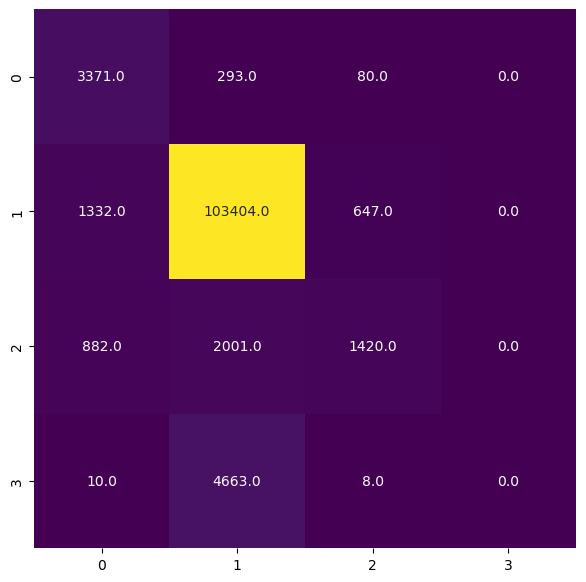

In [12]:
dt = DecisionTreeClassifier(labelCol="Severity", featuresCol="features", maxDepth=10, maxBins=64, 
                            minInstancesPerNode=round(0.005*n), impurity='entropy')
dt = dt.fit(trainingData)
predictions = dt.transform(testData)
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(4):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/4
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

Undersampling Severity target

In [13]:
g_p=g.toPandas()
n_0=g_p.iloc[0,1]
n_1=g_p.iloc[1,1]
n_2=g_p.iloc[2,1]
n_3=g_p.iloc[3,1]

In [14]:
und=(n_0+n_2+n_3)/3
train_und = trainingData.sampleBy('Severity', fractions={0:1.0 ,1: und/n_1 , 2:1.0, 3:1.0})
result_counts=train_und.groupBy("Severity").count()
result_counts.show()

+--------+-----+
|Severity|count|
+--------+-----+
|       1| 9697|
|       3|10956|
|       2| 9859|
|       0| 8918|
+--------+-----+



Training & Test a DT 

In [15]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier

dt = DecisionTreeClassifier(labelCol="Severity", featuresCol="features")

dt = dt.fit(train_und)

In [16]:
dt.featureImportances

SparseVector(28, {0: 0.1138, 1: 0.0592, 2: 0.5652, 3: 0.0001, 19: 0.0117, 20: 0.141, 21: 0.0798, 22: 0.0293})

In [17]:
predictions = dt.transform(testData)
evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

0.5784897257664401
Test Error = 0.42151


In [18]:
prediction_counts = predictions.groupBy("Severity").count()
prediction_counts.show()

+--------+------+
|Severity| count|
+--------+------+
|       1|105383|
|       3|  4681|
|       2|  4303|
|       0|  3744|
+--------+------+



In [19]:
prediction_counts = predictions.groupBy("prediction").count()
print("Counts of predictions in the test set:")
prediction_counts.show()

Counts of predictions in the test set:
+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 5691|
|       1.0|59532|
|       2.0|11657|
|       3.0|41231|
+----------+-----+



In [20]:
preds_and_labels = predictions.select(['prediction','Severity']).withColumn('label', F.col('Severity').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix())

/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


DenseMatrix([[3.3800e+03, 4.2000e+01, 2.8400e+02, 3.8000e+01],
             [1.6080e+03, 5.8204e+04, 8.0750e+03, 3.7496e+04],
             [6.9400e+02, 3.1600e+02, 3.1690e+03, 1.2400e+02],
             [9.0000e+00, 9.7000e+02, 1.2900e+02, 3.5730e+03]])


Train & Test a tuned DT with Severity Undersampling

In [21]:
n=train_und.count()
max_depth=[5,15,10,25]
max_bins=[32,64]
min_inst=[round(0.005*n),round(0.02*n)]
impurity=['entropy', 'gini']

0.6039318945737484
Test Error = 0.396068


/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 62.35%
Recall for class  0 : 87.53%
avg_F1-Score for class  0 : 72.82%
----------------------------
Precision for class  1 : 98.16%
Recall for class  1 : 57.80%
avg_F1-Score for class  1 : 72.76%
----------------------------
Precision for class  2 : 26.09%
Recall for class  2 : 80.85%
avg_F1-Score for class  2 : 39.45%
----------------------------
Precision for class  3 : 9.77%
Recall for class  3 : 78.17%
avg_F1-Score for class  3 : 17.37%
----------------------------
[0.7282222222222221, 0.7275984806860801, 0.3944668065083055, 0.17366335223901846]
----------------------
avg_F1-Score: 50.60%


<AxesSubplot:>

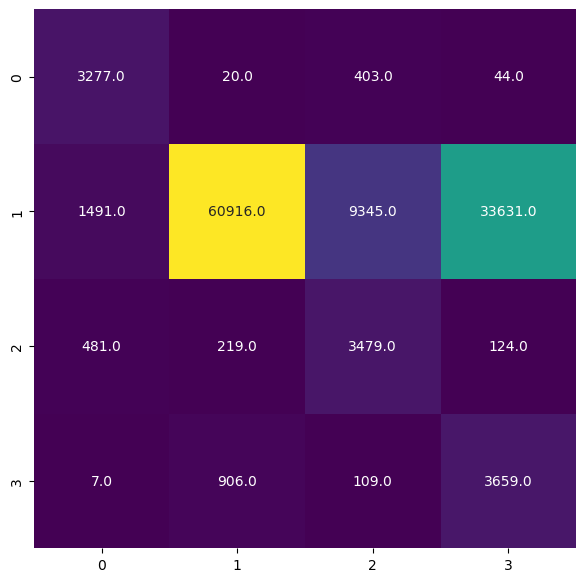

In [22]:
dt = DecisionTreeClassifier(labelCol="Severity", featuresCol="features", maxDepth=15, maxBins=64, 
                            minInstancesPerNode=round(0.005*n), impurity='entropy')
dt = dt.fit(train_und)
predictions = dt.transform(testData)
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(4):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/4
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

Performing Undersampling(Severity=1) & Oversampling(Severity=0,2,3) 

In [23]:
under_1=trainingData.filter(col('Severity') == 1)
under_1 = trainingData.sample(True, 0.3, seed=42)

In [24]:
oversample_0=trainingData.filter(col('Severity') == 0)
num_campioni_da_generare = round(n_1*0.3)
num_campioni_da_generare=(num_campioni_da_generare-n_0)/n_0 
full_0=oversample_0

while num_campioni_da_generare>1:
    oversample_0 = oversample_0.unionAll(full_0)
    num_campioni_da_generare=num_campioni_da_generare-1.0
    print(num_campioni_da_generare)
    
df_minority_oversampled = full_0.sample(True, num_campioni_da_generare, seed=42)

oversample_0 = oversample_0.unionAll(df_minority_oversampled)

6.298048889885624
5.298048889885624
4.298048889885624
3.2980488898856244
2.2980488898856244
1.2980488898856244
0.2980488898856244


In [25]:
oversample_2=trainingData.filter(col('Severity') == 2)
num_campioni_da_generare = round(n_1*0.3)
num_campioni_da_generare=(num_campioni_da_generare-n_2)/n_2
full_2=oversample_2

while num_campioni_da_generare>1:
    oversample_2 = oversample_2.unionAll(full_2)
    num_campioni_da_generare=num_campioni_da_generare-1.0
    print(num_campioni_da_generare)
    
df_minority_oversampled = full_2.sample(True, num_campioni_da_generare, seed=42)

oversample_2 = oversample_2.unionAll(df_minority_oversampled)

5.5060350948372045
4.5060350948372045
3.5060350948372045
2.5060350948372045
1.5060350948372045
0.5060350948372045


In [26]:
oversample_3=trainingData.filter(col('Severity') == 3)
num_campioni_da_generare = round(n_1*0.3)
num_campioni_da_generare=(num_campioni_da_generare-n_3)/n_3  
full_3=oversample_3

while num_campioni_da_generare>1:
    oversample_3 = oversample_3.unionAll(full_3)
    num_campioni_da_generare=num_campioni_da_generare-1.0
    print(num_campioni_da_generare)
    
df_minority_oversampled = full_3.sample(True, num_campioni_da_generare, seed=42)

oversample_3 = oversample_3.unionAll(df_minority_oversampled)

4.754472435195327
3.7544724351953267
2.7544724351953267
1.7544724351953267
0.7544724351953267


In [27]:
class0_counts=oversample_0.count()
class2_counts=oversample_2.count()
class3_counts=oversample_3.count()
class1_counts=under_1.count()
print(f'Class 0: {class0_counts}\nClass 1: {class1_counts}\nClass 2: {class2_counts}\nClass 3: {class3_counts}')

Class 0: 73994
Class 1: 83020
Class 2: 73987
Class 3: 73830


In [28]:
train_und_over=oversample_0.unionAll(oversample_2).unionAll(oversample_3).unionAll(under_1)

In [29]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier

dt = DecisionTreeClassifier(labelCol="Severity", featuresCol="features")

dt = dt.fit(train_und_over)

23/12/14 22:20:43 WARN DAGScheduler: Broadcasting large task binary with size 1352.8 KiB
23/12/14 22:21:00 WARN DAGScheduler: Broadcasting large task binary with size 1964.9 KiB
23/12/14 22:21:00 WARN DAGScheduler: Broadcasting large task binary with size 1965.0 KiB
23/12/14 22:21:16 WARN DAGScheduler: Broadcasting large task binary with size 1969.7 KiB
23/12/14 22:21:30 WARN DAGScheduler: Broadcasting large task binary with size 1971.5 KiB
23/12/14 22:21:43 WARN DAGScheduler: Broadcasting large task binary with size 1972.3 KiB
23/12/14 22:21:44 WARN DAGScheduler: Broadcasting large task binary with size 1972.9 KiB
23/12/14 22:21:45 WARN DAGScheduler: Broadcasting large task binary with size 1974.2 KiB
23/12/14 22:21:46 WARN DAGScheduler: Broadcasting large task binary with size 1976.6 KiB


In [30]:
dt.featureImportances

SparseVector(28, {0: 0.1057, 1: 0.0627, 2: 0.55, 3: 0.0001, 19: 0.0131, 20: 0.151, 21: 0.0861, 22: 0.0312})

In [31]:
predictions = dt.transform(testData)
evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))
from pyspark.mllib.evaluation import MulticlassMetrics
# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(4):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem
    
avg_f1=sum_/4
print('----------------------')
    
print("avg_F1-Score: {:.2%}".format(avg_f1))
    
    


0.5796750514346674
Test Error = 0.420325


Precision for class  0 : 58.85%
Recall for class  0 : 91.08%
avg_F1-Score for class  0 : 71.50%
----------------------------
Precision for class  1 : 97.76%
Recall for class  1 : 55.35%
avg_F1-Score for class  1 : 70.68%
----------------------------
Precision for class  2 : 28.20%
Recall for class  2 : 72.58%
avg_F1-Score for class  2 : 40.62%
----------------------------
Precision for class  3 : 8.67%
Recall for class  3 : 77.06%
avg_F1-Score for class  3 : 15.59%
----------------------------
[0.715034598448312, 0.7067847751535935, 0.4061910645769656, 0.15594128963922094]
----------------------
avg_F1-Score: 49.60%


<AxesSubplot:>

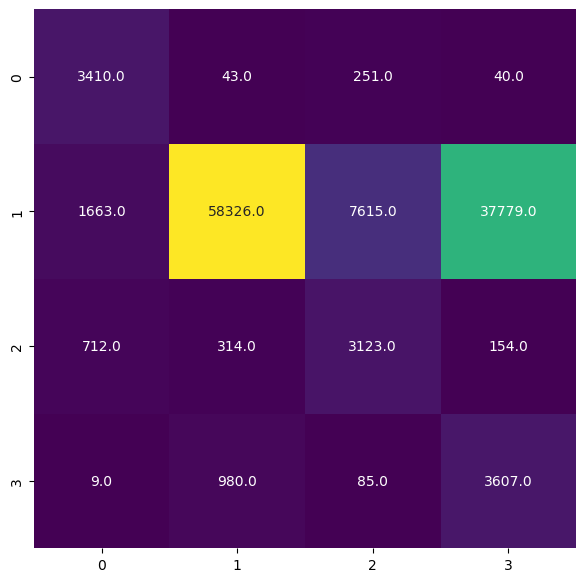

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
 
labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

Train & Test a tuned DT with Severity Undersampling + Oversampling

In [33]:
n=train_und_over.count()
max_depth=[5,15,10,25]
max_bins=[32,64]
min_inst=[round(0.005*n),round(0.02*n)]
impurity=['entropy', 'gini']

23/12/14 22:23:45 WARN DAGScheduler: Broadcasting large task binary with size 1330.3 KiB


23/12/14 22:24:46 WARN DAGScheduler: Broadcasting large task binary with size 1352.8 KiB
23/12/14 22:25:02 WARN DAGScheduler: Broadcasting large task binary with size 1964.9 KiB
23/12/14 22:25:02 WARN DAGScheduler: Broadcasting large task binary with size 1965.0 KiB
23/12/14 22:25:18 WARN DAGScheduler: Broadcasting large task binary with size 1969.7 KiB
23/12/14 22:25:32 WARN DAGScheduler: Broadcasting large task binary with size 1973.0 KiB
23/12/14 22:25:46 WARN DAGScheduler: Broadcasting large task binary with size 1973.7 KiB
23/12/14 22:25:47 WARN DAGScheduler: Broadcasting large task binary with size 1974.4 KiB
23/12/14 22:25:48 WARN DAGScheduler: Broadcasting large task binary with size 1975.6 KiB
23/12/14 22:25:49 WARN DAGScheduler: Broadcasting large task binary with size 1978.0 KiB
23/12/14 22:25:49 WARN DAGScheduler: Broadcasting large task binary with size 1982.1 KiB
23/12/14 22:25:50 WARN DAGScheduler: Broadcasting large task binary with size 1988.4 KiB
23/12/14 22:25:51 WAR

0.6498717308294739
Test Error = 0.350128


Precision for class  0 : 59.62%
Recall for class  0 : 88.11%
avg_F1-Score for class  0 : 71.12%
----------------------------
Precision for class  1 : 97.97%
Recall for class  1 : 63.19%
avg_F1-Score for class  1 : 76.82%
----------------------------
Precision for class  2 : 28.49%
Recall for class  2 : 79.32%
avg_F1-Score for class  2 : 41.92%
----------------------------
Precision for class  3 : 10.59%
Recall for class  3 : 73.83%
avg_F1-Score for class  3 : 18.53%
----------------------------
[0.7112212999892206, 0.7682385855614202, 0.41918447555883076, 0.18527850747868974]
----------------------
avg_F1-Score: 52.10%


<AxesSubplot:>

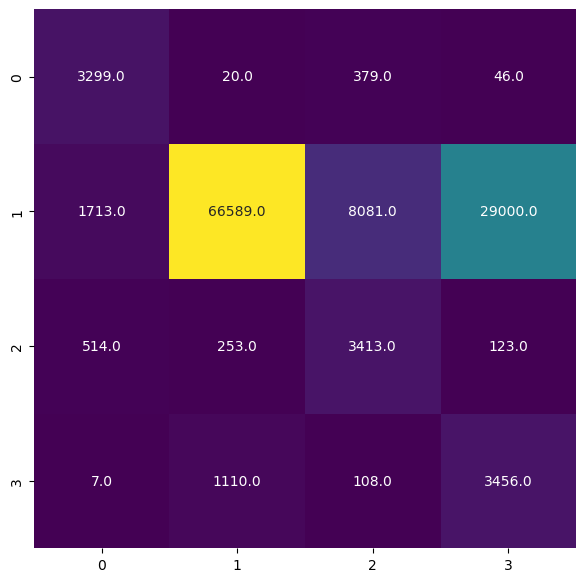

In [34]:
dt = DecisionTreeClassifier(labelCol="Severity", featuresCol="features", maxDepth=15, maxBins=64, 
                            minInstancesPerNode=round(0.005*n), impurity='entropy')
dt = dt.fit(train_und_over)
predictions = dt.transform(testData)
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="Severity"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(4):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/4
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1", "2", "3"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

# Train & Test DT with Working_Weekend target

In [4]:
ww_counts = df_DT_binary.groupBy("Working_Weekend").count()
ww_counts.show()

+---------------+------+
|Working_Weekend| count|
+---------------+------+
|              1| 82649|
|              0|311870|
+---------------+------+



In [5]:
num_col = [item[0] for item in df_class.dtypes if not item[1].startswith('string')]
num_col.remove("Working_Weekend")
assembler = VectorAssembler(inputCols=num_col, outputCol="features")

output_dataset = assembler.transform(df_DT_binary)

classificationData = output_dataset.select("features", "Working_Weekend")

classificationData.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------+---------------+
|features                                                                                                         |Working_Weekend|
+-----------------------------------------------------------------------------------------------------------------+---------------+
|(28,[0,1,2,4,5,6,18,21,22,24],[1.0,33.032551,-81.346909,30.0,93.0,10.0,1.0,3.0,6.0,1.0])                         |0              |
|(28,[0,1,2,3,4,5,6,7,18,21,22,25],[1.0,33.023018,-81.274361,0.129,73.0,47.0,10.0,6.0,1.0,3.0,14.0,1.0])          |0              |
|(28,[0,1,2,3,4,5,6,7,21,22,24],[1.0,33.023848,-81.33301800000002,0.122,82.0,15.0,10.0,7.0,3.0,14.0,1.0])         |0              |
|(28,[0,1,2,4,5,6,21,22],[1.0,33.087425,-81.208588,46.0,100.0,0.25,3.0,7.0])                                      |0              |
|(28,[0,1,2,4,5,6,18,21,22,24],[1.0,33.06987,-81.424118,59.0,94.0,10.0,1.0,3

In [6]:
(trainingData, testData) = classificationData.randomSplit([0.7, 0.3],seed=0)

In [37]:
ww_counts_train= trainingData.groupBy("Working_Weekend").count()
ww_counts_train.show()

+---------------+------+
|Working_Weekend| count|
+---------------+------+
|              1| 57814|
|              0|218652|
+---------------+------+



In [38]:
ww_counts_test= testData.groupBy("Working_Weekend").count()
ww_counts_test.show()

+---------------+-----+
|Working_Weekend|count|
+---------------+-----+
|              1|24835|
|              0|93218|
+---------------+-----+



In [7]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier

dt = DecisionTreeClassifier(labelCol="Working_Weekend", featuresCol="features")

dt = dt.fit(trainingData)

In [8]:
dt.featureImportances

SparseVector(28, {0: 0.0786, 1: 0.0227, 3: 0.2868, 4: 0.1676, 5: 0.003, 7: 0.0042, 8: 0.0102, 22: 0.1774, 23: 0.2495})

In [9]:
predictions = dt.transform(testData)

In [10]:
evaluator = MulticlassClassificationEvaluator(labelCol="Working_Weekend"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

0.7925002751648873
Test Error = 0.2075


In [11]:
from pyspark.mllib.evaluation import MulticlassMetrics
# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Working_Weekend").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(2):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/2
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 79.43%
Recall for class  0 : 99.49%
avg_F1-Score for class  0 : 88.34%
----------------------------
Precision for class  1 : 62.84%
Recall for class  1 : 3.24%
avg_F1-Score for class  1 : 6.16%
----------------------------
[0.8833530061302973, 0.06164331112642622]
----------------------
avg_F1-Score: 47.25%


<AxesSubplot:>

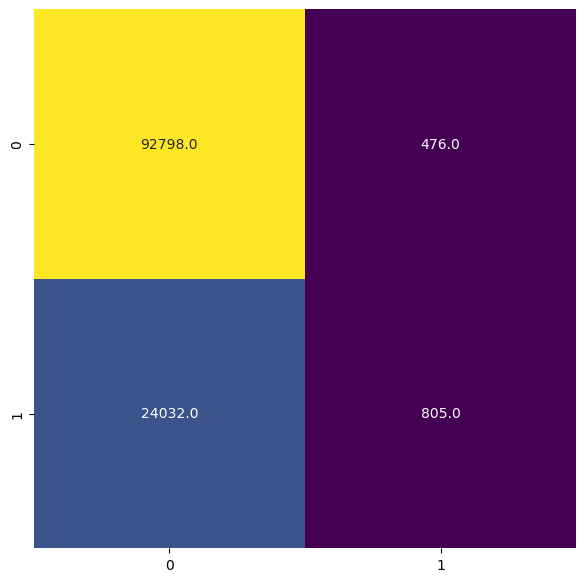

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["0", "1"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)

Train & Test a tuned DT with Working_Weekend

In [13]:
n=trainingData.count()
max_depth=[5,15,10,25]
max_bins=[32,64]
min_inst=[round(0.005*n),round(0.02*n)]
impurity=['entropy', 'gini']

CodeCache: size=131072Kb used=45464Kb max_used=45469Kb free=85607Kb
 bounds [0x000000010a9d8000, 0x000000010d698000, 0x00000001129d8000]
 total_blobs=15889 nmethods=14824 adapters=977
 compilation: disabled (not enough contiguous free space left)


Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


0.7912302833775008
Test Error = 0.20877


/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision for class  0 : 79.90%
Recall for class  0 : 98.29%
avg_F1-Score for class  0 : 88.15%
----------------------------
Precision for class  1 : 52.66%
Recall for class  1 : 7.13%
avg_F1-Score for class  1 : 12.55%
----------------------------
[0.8814656001230627, 0.1255408184977658]
----------------------
avg_F1-Score: 50.35%


<AxesSubplot:>

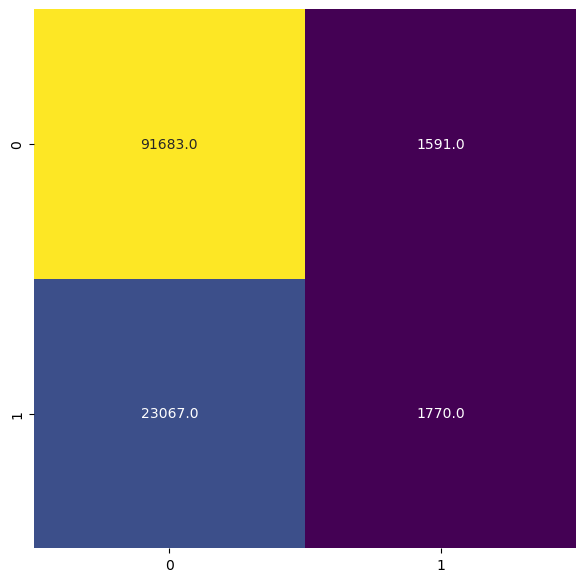

In [15]:
dt = DecisionTreeClassifier(labelCol="Working_Weekend", featuresCol="features", maxDepth=15, maxBins=64, 
                            minInstancesPerNode=round(0.005*n), impurity='entropy')
dt = dt.fit(trainingData)
predictions = dt.transform(testData)
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(labelCol="Working_Weekend"
                                              , predictionCol="prediction"
                                              , metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(accuracy)
print("Test Error = %g" % (1.0 - accuracy))

# Calcolare precision, recall e F1-score
predictionAndLabels = predictions.select("prediction", "Working_Weekend").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(predictionAndLabels)

list_avg=[]
for i in range(2):
    precision = metrics.precision(label=float(i))  
    recall = metrics.recall(label=float(i))
    f1Score= metrics.fMeasure(label=float(i)) # need .0
    print("Precision for class ",i,": {:.2%}".format(precision))
    print("Recall for class ",i,": {:.2%}".format(recall))
    print("avg_F1-Score for class ",i,": {:.2%}".format(f1Score))
    list_avg.append(f1Score)
    print('----------------------------')
sum_=0
print(list_avg)
for elem in list_avg:
    sum_+=elem

avg_f1=sum_/2
print('----------------------')

print("avg_F1-Score: {:.2%}".format(avg_f1))

labels = ["0", "1"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=labels, 
            yticklabels=labels)